Train a small Transformer on this toy dataset:

texts = [
    ("i love ai", 1),
    ("ai is hard", 0),
    ("i love transformers", 1),
    ("attention helps learning", 1),
    ("i hate bugs", 0),
]


Tasks:

Tokenize and pad each sentence.

Build a simple Transformer classifier.

Train for 10 epochs.

Plot training loss.

Visualize attention heatmaps for “i love ai” vs “i hate bugs”.

In [12]:
# ===============================================================
# 1. SETUP: Imports, Dataset, Tokenization, Vocabulary
# ===============================================================
import torch, math, re, matplotlib.pyplot as plt
from torch import nn
from collections import Counter

torch.manual_seed(42)  # reproducible on CPU

# ----- Toy dataset -----
texts = [
    ("i love ai", 1),
    ("ai is hard", 0),
    ("i love transformers", 1),
    ("attention helps learning", 1),
    ("i hate bugs", 0),
]

PAD, UNK, CLS = "<pad>", "<unk>", "<cls>"

def tokenize(s):
    return re.findall(r"\w+", s.lower())

# ----- Build vocabulary -----
counter = Counter()
for t, _ in texts:
    counter.update(tokenize(t))
itos = [PAD, UNK, CLS] + sorted(counter)
stoi = {w: i for i, w in enumerate(itos)}
vocab_size = len(stoi)
print("Vocabulary:", stoi)

# ----- Encode sentences -----
def encode(s, max_len=6):
    toks = [CLS] + tokenize(s)
    ids = [stoi.get(tok, stoi[UNK]) for tok in toks][:max_len]
    ids += [stoi[PAD]] * (max_len - len(ids))
    return torch.tensor(ids)

X = torch.stack([encode(t) for t,_ in texts])
y = torch.tensor([lab for _, lab in texts])
print("Encoded input shape:", X.shape)


Vocabulary: {'<pad>': 0, '<unk>': 1, '<cls>': 2, 'ai': 3, 'attention': 4, 'bugs': 5, 'hard': 6, 'hate': 7, 'helps': 8, 'i': 9, 'is': 10, 'learning': 11, 'love': 12, 'transformers': 13}
Encoded input shape: torch.Size([5, 6])


In [13]:
# ===============================================================
# 2. POSITIONAL ENCODING
# ===============================================================
def positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    pos = torch.arange(0, seq_len).unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2)*(-math.log(10000.0)/d_model))
    pe[:, 0::2] = torch.sin(pos * div)
    pe[:, 1::2] = torch.cos(pos * div)
    return pe


In [14]:
# ===============================================================
# 3️. CUSTOM TRANSFORMER LAYER (records attention weights)
# ===============================================================
class CustomEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=64, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.last_attn = None  # store attention weights

    def forward(self, x):
        attn_out, attn_weights = self.self_attn(x, x, x, need_weights=True)
        self.last_attn = attn_weights.detach()  # [B, heads, T, T]
        x = self.norm1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


In [15]:
# ===============================================================
# 4️. TINY TRANSFORMER CLASSIFIER
# ===============================================================
class TinyTransformer(nn.Module):
    def __init__(self, vocab, d_model=32, heads=2, layers=2, n_classes=2, max_len=10):
        super().__init__()
        self.emb = nn.Embedding(vocab, d_model)
        self.register_buffer("pe", positional_encoding(max_len, d_model))
        self.layers = nn.ModuleList([CustomEncoderLayer(d_model, heads) for _ in range(layers)])
        self.cls = nn.Linear(d_model, n_classes)

    def forward(self, x):
        B, T = x.shape
        x = self.emb(x) + self.pe[:T].unsqueeze(0)
        for layer in self.layers:
            x = layer(x)
        cls_vec = x[:, 0, :]  # take CLS token output
        return self.cls(cls_vec)


Epoch 1: Loss = 0.7784
Epoch 2: Loss = 0.7646
Epoch 3: Loss = 0.5815
Epoch 4: Loss = 0.6144
Epoch 5: Loss = 0.5978
Epoch 6: Loss = 0.5218
Epoch 7: Loss = 0.4179
Epoch 8: Loss = 0.3022
Epoch 9: Loss = 0.2171
Epoch 10: Loss = 0.2112


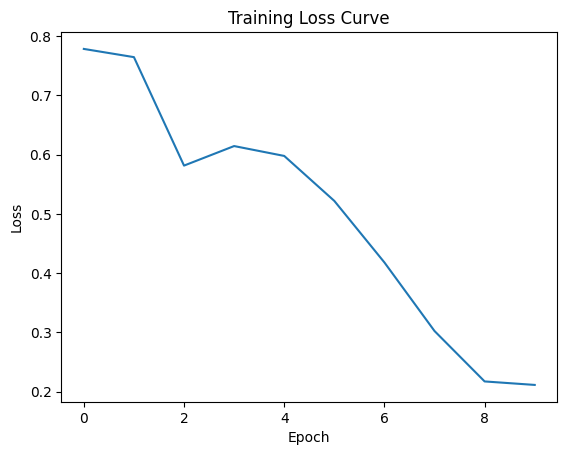

In [16]:
# ===============================================================
# 5️. TRAINING LOOP
# ===============================================================
model = TinyTransformer(vocab_size, d_model=32)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=5e-3)

losses = []
for epoch in range(10):
    model.train()
    opt.zero_grad()
    logits = model(X)
    loss = loss_fn(logits, y)
    loss.backward()
    opt.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

plt.plot(losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [18]:
# ===============================================================
# 6️. INFERENCE (Prediction)
# ===============================================================
model.eval()
with torch.no_grad():
    test_sentences = ["i love ai", "i hate bugs"]
    for s in test_sentences:
        ids = encode(s).unsqueeze(0)
        probs = torch.softmax(model(ids), dim=-1)
        print(f"{s:25s} → probs = {probs.squeeze().tolist()}")


i love ai                 → probs = [0.13298308849334717, 0.8670169115066528]
i hate bugs               → probs = [0.974789559841156, 0.025210462510585785]
